Exponential Fit Curve-fitted Variables: qi= 2,190.00, di = 10.00
Hyperbolic Fit Curve-fitted Variables: qi= 5,160.83 b = 0.00, di= 0.00


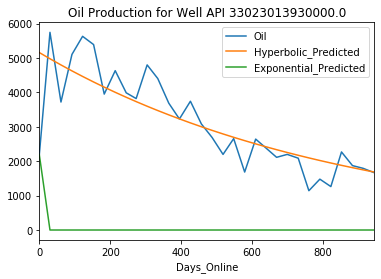

Exponential Fit Curve-fitted Variables: qi= 14,265.13, di = 10.00
Hyperbolic Fit Curve-fitted Variables: qi= 13,729.78 b = 1.75, di= 0.02


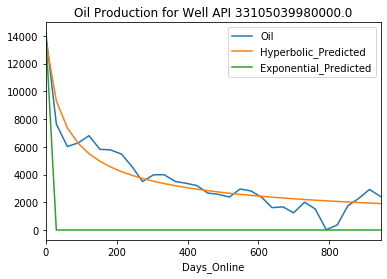

Exponential Fit Curve-fitted Variables: qi= 18,190.89, di = 10.00
Hyperbolic Fit Curve-fitted Variables: qi= 18,192.00 b = 1.74, di= 0.02


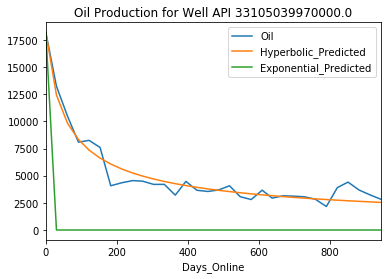

Exponential Fit Curve-fitted Variables: qi= 11,070.32, di = 10.00
Hyperbolic Fit Curve-fitted Variables: qi= 11,071.00 b = 1.27, di= 0.01


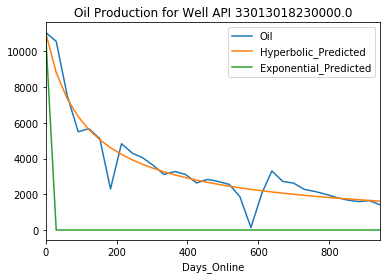

Exponential Fit Curve-fitted Variables: qi= 15,498.05, di = 10.00
Hyperbolic Fit Curve-fitted Variables: qi= 15,499.00 b = 1.29, di= 0.01


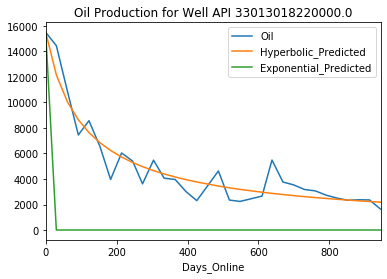

Exponential Fit Curve-fitted Variables: qi= 2,190.00, di = 10.00
Hyperbolic Fit Curve-fitted Variables: qi= 5,160.83 b = 0.00, di= 0.00


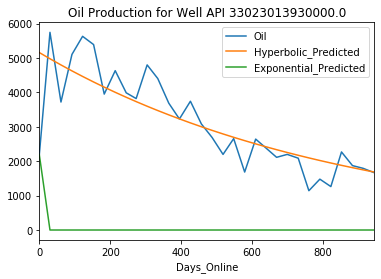

Exponential Fit Curve-fitted Variables: qi= 14,265.13, di = 10.00
Hyperbolic Fit Curve-fitted Variables: qi= 13,729.78 b = 1.75, di= 0.02


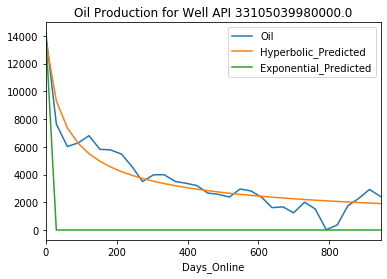

Exponential Fit Curve-fitted Variables: qi= 18,190.89, di = 10.00
Hyperbolic Fit Curve-fitted Variables: qi= 18,192.00 b = 1.74, di= 0.02


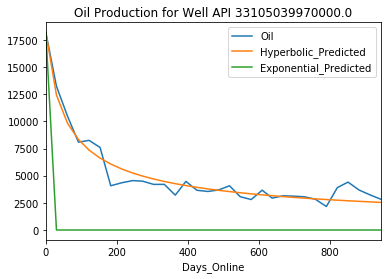

Exponential Fit Curve-fitted Variables: qi= 11,070.32, di = 10.00
Hyperbolic Fit Curve-fitted Variables: qi= 11,071.00 b = 1.27, di= 0.01


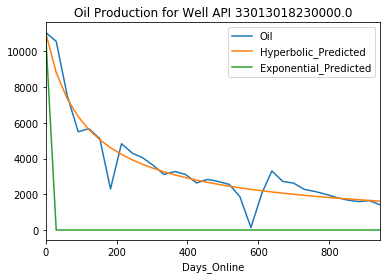

Exponential Fit Curve-fitted Variables: qi= 15,498.05, di = 10.00
Hyperbolic Fit Curve-fitted Variables: qi= 15,499.00 b = 1.29, di= 0.01


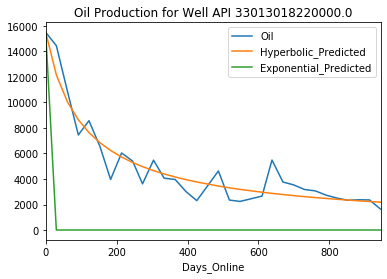

In [19]:
import pandas as pd
from scipy.optimize import curve_fit
import numpy as np
import matplotlib.pyplot as plt

def read_in_csv(file_path):
    """
    Read in the specified csv as a pandas dataframe
    Arguments: 
        file_path: String. Path for the csv file that we want to read in
    Outputs:
        dataframe: Pandas dataframe.
    """
    dataframe=pd.read_csv(file_path)
    return dataframe

def hyperbolic_equation(t, qi, b, di):
    """
    Hyperbolic decline curve equation
    Arguments:
        t: Float. Time since the well first came online, can be in various units 
        (days, months, etc) so long as they are consistent.
        qi: Float. Initial production rate when well first came online.
        b: Float. Hyperbolic decline constant
        di: Float. Nominal decline rate at time t=0
    Output: 
        Returns q, or the expected production rate at time t. Float.
    """
    return qi/((1.0+b*di*t)**(1.0/b))

def exponential_equation(t, qi, di):
    """
    Exponential decline curve equation
    Arguments:
        t: Float. Time since the well first came online, can be in various units 
        (days, months, etc) so long as they are consistent.
        qi: Float. Initial production rate when well first came online.
        di: Float. Nominal decline rate (constant)
    Output: 
        Returns q, or the expected production rate at time t. Float.
    """
    return qi*np.exp(-di*t)

def remove_nan_and_zeroes_from_columns(df: pd.DataFrame, variable):
    """
    This function cleans up a dataframe by removing rows in a specific 
    column that are null/NaN or equal to 0. This basically removes zero 
    production time periods.
    Arguments:
        df: Pandas dataframe.
        variable: String. Name of the column where we want to filter out
        NaN's or 0 values
    Output:
        filtered_df: Pandas dataframe. Dataframe with NaN's and zeroes filtered out of 
        the specified column
    """
    filtered_df = df[(df[variable].notnull()) & (df[variable]>0)]
    return filtered_df

def generate_time_delta_column(df: pd.DataFrame, time_column, date_first_online_column):
    """
    Create column for the time that a well has been online at each reading, with 
    the first non-null month in the series listed as the start of production
    Arguments:
        df: Pandas dataframe
        time_column: String. Name of the column that includes the specific record date
        that the data was taken at. Column type is pandas datetime
        date_first_online_column: Name of the column that includes the date that the
        well came online. Column type is pandas datetime
    Outputs:
        Pandas series containing the difference in days between the date the well
        came online and the date that the data was recorded (cumulative days online)
    """
    return (df[time_column]-df[date_first_online_column]).dt.days
    
def get_min_or_max_value_in_column_by_group(df: pd.DataFrame, group_by_column, calc_column, calc_type):
    """
    This function obtains the min or max value for a column, with a group by applied. For example,
    it could return the earliest (min) RecordDate for each API number in a dataframe 
    Arguments:
        dataframe: Pandas dataframe 
        group_by_column: string. Name of column that we want to apply a group by to
        calc_column: string. Name of the column that we want to get the aggregated max or min for
        calc_type: string; can be either 'min' or 'max'. Defined if we want to pull the min value 
        or the max value for the aggregated column
    Outputs:
        value: Depends on the calc_column type.
    """
    value=df.groupby(group_by_column)[calc_column].transform(calc_type)
    return value

def get_max_initial_production(df: pd.DataFrame, number_first_months: int, variable_column: str, date_column: str):
    """
    This function allows you to look at the first X months of production, and selects 
    the highest production month as max initial production
    Arguments:
        df: Pandas dataframe. 
        number_first_months: float. Number of months from the point the well comes online
        to compare to get the max initial production rate qi (this looks at multiple months
        in case there is a production ramp-up)
        variable_column: String. Column name for the column where we're attempting to get
        the max volume from (can be either 'Gas' or 'Oil' in this script)
        date_column: String. Column name for the date that the data was taken at 
    :Returns: max value in the selected variable column from the newly created df_beginning_production
    
    """
    df=df.sort_values(by=date_column)
    df_beginning_production=df.head(number_first_months)
    
    return df_beginning_production[variable_column].max()

def plot_actual_vs_predicted_by_equations(df: pd.DataFrame, x_variable, y_variables, plot_title):
    """
    This function is used to map x- and y-variables against each other
    Arguments:
        df: Pandas dataframe.
        x_variable: String. Name of the column that we want to set as the 
        x-variable in the plot
        y_variables: string (single), or list of strings (multiple). Name(s) 
        of the column(s) that we want to set as the y-variable in the plot
    :Returns: Plot
    """
    df.plot(x=x_variable, y=y_variables, title=plot_title)
    return plt.show()

def main():
    file_path='master_dataframe_production.csv'
    desired_product_type='Oil' # or 'Gas'
    
    bakken_data=read_in_csv(file_path)
    bakken_data['ReportDate']=pd.to_datetime(bakken_data['ReportDate'])

    bakken_data=remove_nan_and_zeroes_from_columns(bakken_data, desired_product_type)

    bakken_data['Online_Date']= get_min_or_max_value_in_column_by_group(bakken_data, group_by_column='API_WELLNO', 
                  calc_column='ReportDate', calc_type='min')
    #Generate column for time online delta
    bakken_data['Days_Online']=generate_time_delta_column(bakken_data, time_column='ReportDate', 
                  date_first_online_column='Online_Date')
    #Pull data that came online between January and June 2016
    bakken_data_2016=bakken_data
   
    #Get a list of unique API's to loop through--these were randomly selected as examples
    unique_well_APIs_list=[33023013930000.0, 33105039980000.0, 33105039970000.0, 
                           33013018230000.0, 33013018220000.0]
    #Loop through each API, and perform calculations
    for api_number in unique_well_APIs_list:
        #Subset the dataframe by API Number
        production_time_series=bakken_data_2016[bakken_data_2016.API_WELLNO==api_number]
        #Get the highest value of production in the first three months of production, to use as qi value
        qi=get_max_initial_production(production_time_series, 3, desired_product_type, 'ReportDate')
        #Exponential curve fit the data to get best fit equation
        popt_exp, pcov_exp=curve_fit(exponential_equation, production_time_series['Days_Online'], 
                                     production_time_series[desired_product_type],bounds=(0, [qi,20]))
        print('Exponential Fit Curve-fitted Variables: qi= {qi:,.2f}, di = {di:,.2f}'
              .format(qi = popt_exp[0], di = popt_exp[1]))
        #Hyperbolic curve fit the data to get best fit equation
        popt_hyp, pcov_hyp=curve_fit(hyperbolic_equation, production_time_series['Days_Online'], 
                                     production_time_series[desired_product_type],bounds=(0, [qi,2,20]))
        print('Hyperbolic Fit Curve-fitted Variables: qi= {qi:,.2f} b = {b:,.2f}, di= {di:,.2f}'
              .format(qi = popt_hyp[0], b = popt_hyp[1], di = popt_hyp[2]))
        #Exponential fit results
        production_time_series.loc[:,'Exponential_Predicted']=exponential_equation(production_time_series['Days_Online'], 
                                  *popt_exp)
        #Hyperbolic fit results
        production_time_series.loc[:,'Hyperbolic_Predicted']=hyperbolic_equation(production_time_series['Days_Online'], 
                                  *popt_hyp)
        #Declare the x- and y- variables that we want to plot against each other
        y_variables=[desired_product_type, "Hyperbolic_Predicted", "Exponential_Predicted"]
        x_variable='Days_Online'
        #Create the plot title
        title = [desired_product_type,' Production for Well API ',str(api_number)]
        plot_title= "".join(title)
        #Plot the data to visualize the equation fit
        plot_actual_vs_predicted_by_equations(production_time_series, x_variable, y_variables, plot_title)
    return bakken_data     
if __name__== "__main__":
    main()
    data = main()

In [2]:
%matplotlib inline

In [5]:
bakken_data.head()

NameError: name 'bakken_data' is not defined

In [8]:
data.tail()

,Unnamed: 0,Unnamed: 0.1,ReportDate,API_WELLNO,FileNo,Company,WellName,Quarter,Section,Township,...,Wtr,Days,Runs,Gas,GasSold,Flared,Lat,Long,Online_Date,Days_Online
26036,600942,17308,2019-01-01,3.301301e+13,3520.0,"PETRO HARVESTER OPERATING COMPANY, LLC",AAGE CHRISTIANSEN 3,NWNW,3.0,162.0,...,2.0,1.0,0.0,1.0,1.0,0.0,48.892432,-102.346268,2016-02-01,1065
26037,600945,17311,2019-01-01,3.301301e+13,5969.0,"PETRO HARVESTER OPERATING COMPANY, LLC",AAGE CHRISTIANSEN 6,SESE,34.0,163.0,...,50.0,29.0,54.0,69.0,69.0,0.0,48.896057,-102.329733,2016-05-01,975
26038,600948,17314,2019-01-01,3.301300e+13,2781.0,"PETRO HARVESTER OPERATING COMPANY, LLC",GEHRKE HEIRS 1,SESW,8.0,162.0,...,77.0,31.0,168.0,547.0,547.0,0.0,48.867035,-102.384569,2016-01-01,1096
26039,600968,17334,2019-01-01,3.302503e+13,32050.0,MARATHON OIL COMPANY,MARTINEZ USA 24-8H,NWNE,17.0,146.0,...,4603.0,31.0,3834.0,1400.0,973.0,18.0,47.470754,-102.425092,2016-02-01,1065
26040,600986,17352,2019-01-01,3.302301e+13,26196.0,MUREX PETROLEUM CORPORATION,DIANE RENEE 3-10H,LOT2,3.0,161.0,...,14448.0,31.0,4557.0,524.0,0.0,121.0,48.807107,-103.781163,2016-01-01,1096


In [20]:
data[data['API_WELLNO']==33023013930000.0].to_csv('short.csv')